<a href="https://colab.research.google.com/github/anniebannannie/coms_6998_final/blob/main/coms6998_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import kagglehub

# Download latest version of IEMOCAP dataset
path = kagglehub.dataset_download("dejolilandry/iemocapfullrelease")

100%|██████████| 11.5G/11.5G [10:25<00:00, 19.8MB/s]

Extracting files...


In [3]:
## Clone ImageBind source code

!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind

Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/ImageBind


In [4]:
# Install the required dependencies
%%capture
!pip install -r requirements.txt
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1
!pip install pytorchvideo
!pip install ftfy
!pip install datasets
!pip install decord[gpu]

In [3]:
## Import required libraries
import sys
import torch
import os
import cv2
import subprocess

from collections import defaultdict
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [6]:
sys.path.append('/content/ImageBind')

In [7]:
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
iemocap_path = path + '/IEMOCAP_full_release'

In [15]:
# Function to load audio file
def load_audio():
    audio_session = {}
    for session in sessions:
        audio_data = {}
        audio_path = os.path.join(iemocap_path, session, "sentences/wav/")
        for session_path in os.listdir(audio_path):
          for file in os.listdir(os.path.join(audio_path, session_path)):
            if file.endswith(".wav"):
              audio_id = os.path.splitext(file)[0]
              file_path = os.path.join(audio_path, session_path, file)
              audio_data[audio_id] = file_path
        audio_session[session] = dict(sorted(audio_data.items()))
    return dict(sorted(audio_session.items()))

In [16]:
# Function to load text transcriptions and get time stamps for videos if specified
def load_text(get_time=False):
    for session in sessions:
        transcriptions_path = os.path.join(iemocap_path, session, "dialog/transcriptions/")
        if get_time:
          video_time_data = {}
        text_dialog_data = {}
        for file in os.listdir(transcriptions_path):
            if file.endswith(".txt"):
                session_id = os.path.splitext(file)[0]
                if get_time:
                  time_data = {}
                text_data = {}
                #file_path = os.path.join(transcriptions_path, file)
                with open(os.path.join(transcriptions_path, file), "r", encoding="utf-8") as f:
                  for line in f:
                    dialog_id = line.split("[")[0].strip()
                    if "Ses" in dialog_id:
                      if get_time:
                        video_time = line.split("[")[1].strip()
                        video_time = video_time.split("]")[0].strip()
                        time_data[dialog_id] = video_time
                      text = line.split(":")[1].strip()
                      text_data[dialog_id] = text
                if get_time:
                  video_time_data[session_id] = dict(sorted(time_data.items()))
                text_dialog_data[session_id] = dict(sorted(text_data.items()))
    if get_time:
      return dict(sorted(text_dialog_data.items())), dict(sorted(video_time_data.items()))
    else:
      return dict(sorted(text_dialog_data.items()))

In [21]:
# function to load emotion labels
def load_labels(save_labels = False):
    label_session = {}
    for session in sessions:
      transcriptions_path = os.path.join(iemocap_path, session, "dialog/EmoEvaluation/")
      label_data = {}
      for file in os.listdir(transcriptions_path):
          if file.endswith(".txt"):
              with open(os.path.join(transcriptions_path, file), "r", encoding="utf-8") as f:
                for line in f:
                  if "Ses" in line:
                    arr = line.split('\t')
                    dialog_id = arr[1]
                    emotion = arr[2]
                    label_data[dialog_id] = [dialog_id,emotion]
      emotion_labels = dict(sorted(label_data.items()))
      emotion_labels = list(emotion_labels.values())
      if save_labels:
        np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/emotion_labels_{session}.csv", emotion_labels, delimiter="," ,fmt="%s")
      label_session[session] = dict(sorted(label_data.items()))
    return dict(sorted(label_session.items()))


In [22]:
def split_video(input_file, start_time, end_time, output_file):
  cmd = [
        "ffmpeg",
        "-i", input_file,
        "-ss", start_time,
        "-t", end_time,
        "-codec", "copy",
        output_file
    ]
  subprocess.run(cmd)

In [45]:
# Function to load video files
def load_video(video_path_output, splice_video=False, video_time_data=None):
  if splice_video:
    for session in sessions:
        video_path = os.path.join(iemocap_path, session, "dialog/avi/DivX")
        video_dialog_data = {}
        for file in os.listdir(video_path):
            if file.endswith(".avi"):
                video_data = {}
                session_id = os.path.splitext(file)[0]
                input_file_path = os.path.join(video_path, file)
                output_file_names = list(video_time_data[session_id].keys())
                print(f"Splitting video {file}......")
                for output in output_file_names:
                  start_time = video_time_data[session_id][output].split("-")[0]
                  end_time = video_time_data[session_id][output].split("-")[1]
                  output_file = os.path.join(video_path_output, session_id, output + ".avi")

                  split_video(input_file_path, start_time, end_time, output_file)
                  video_data[output] = output_file
                video_dialog_data[session_id] = dict(sorted(video_data.items()))
                print(f"Done processing {file}.")
  else:
      video_dialog_data = {}
      for transcript in os.listdir(video_path_output):
        for video in os.listdir(os.path.join(video_path_output, transcript)):
          video_key = transcript + "_" + video.split(".")[0]
          video_dialog_data[video_key] = os.path.join(video_path_output, transcript, video)
          video_dialog_data = dict(sorted(video_dialog_data.items()))

  return dict(sorted(video_dialog_data.items()))

In [46]:
emotion_labels = load_labels()
text_data = load_text()
audio_data = load_audio()
video_data = load_video(video_path_output = "/content/drive/MyDrive/coms6998_final_project/data/video/")


In [48]:
labels = list(emotion_labels.values())
text_list = list(text_data.values())
audio_paths = list(audio_data.values())
video_paths = list(video_data.values())

In [49]:
## LOAD AND INSTANTIATE IMAGEBIND MODEL ##

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [ ]:
num_data = len(text_data)
batch_size = 28

num_batches = int(np.floor(num_data / batch_size))

In [ ]:
def batch_process_all(batch_size, num_data):
  num_batches = int(np.floor(num_data / batch_size))
  for i in range(num_batches):
    j = i + 1
    print(f"Batch {j}/{num_batches}")
    try:
      text_tensor_data = data.load_and_transform_text(text_list[i*batch_size:j*batch_size], device)
      video_tensor_data = data.load_and_transform_video_data(video_paths[i*batch_size:j*batch_size], device)
      audio_tensor_data = data.load_and_transform_audio_data(audio_paths[i*batch_size:j*batch_size], device)

      inputs = {
        ModalityType.TEXT: text_tensor_data,
        ModalityType.VISION: video_tensor_data,
        ModalityType.AUDIO: audio_tensor_data,
        }


      with torch.no_grad():
        embeddings = model(inputs)

      if i == 0:
        labels_save = labels[i*batch_size:j*batch_size]
        vision_embeddings = embeddings[ModalityType.VISION].cpu().numpy()
        audio_embeddings = embeddings[ModalityType.AUDIO].cpu().numpy()
        text_embeddings = embeddings[ModalityType.TEXT].cpu().numpy()
      else:
        labels_save = labels_save + labels[i*batch_size:j*batch_size]
        vision_embeddings = np.concatenate((vision_embeddings, embeddings[ModalityType.VISION].cpu().numpy()), axis=0)
        audio_embeddings = np.concatenate((audio_embeddings, embeddings[ModalityType.AUDIO].cpu().numpy()), axis=0)
        text_embeddings = np.concatenate((text_embeddings, embeddings[ModalityType.TEXT].cpu().numpy()), axis=0)
    except Exception as e:
      print(e)

  return labels_save, audio_embeddings, text_embeddings, vision_embeddings

In [ ]:
def batch_process_audio_text(batch_size, num_data):
  num_batches = int(np.floor(num_data / batch_size))
  for i in range(num_batches):
    j = i + 1
    print(f"Batch {j}/{num_batches}")
    try:
      text_tensor_data = data.load_and_transform_text(text_list[i*batch_size:j*batch_size], device)
      audio_tensor_data = data.load_and_transform_audio_data(audio_paths[i*batch_size:j*batch_size], device)

      inputs = {
        ModalityType.TEXT: text_tensor_data,
        ModalityType.AUDIO: audio_tensor_data,
        }


      with torch.no_grad():
        embeddings = model(inputs)

      if i == 0:
        labels_save = labels[i*batch_size:j*batch_size]
        audio_embeddings = embeddings[ModalityType.AUDIO].cpu().numpy()
        text_embeddings = embeddings[ModalityType.TEXT].cpu().numpy()
      else:
        labels_save = labels_save + labels[i*batch_size:j*batch_size]
        audio_embeddings = np.concatenate((audio_embeddings, embeddings[ModalityType.AUDIO].cpu().numpy()), axis=0)
        text_embeddings = np.concatenate((text_embeddings, embeddings[ModalityType.TEXT].cpu().numpy()), axis=0)
    except Exception as e:
      print(e)

  return labels_save, audio_embeddings, text_embeddings

In [ ]:
### BATCH PROCESSING

sessions = ['Session1']

for session in sessions:
  print(f"Processing session {session}......")
  labels = list(emotion_labels[session].values())
  text_list = list(text_data[session].values())
  audio_paths = list(audio_data[session].values())

  labels_save, audio_embeddings, text_embeddings, vision_embeddings = batch_process_all(batch_size, len(text_list))

  np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/vision_embeddings_{session}.csv", vision_embeddings, delimiter=",")
  np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/audio_embeddings_{session}.csv", audio_embeddings, delimiter=",")
  np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/text_embeddings_{session}.csv", text_embeddings, delimiter=",")
  np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/labels_{session}.csv", labels_save, delimiter="," ,fmt="%s")



Processing session Session1......
Batch 1/64


Batch 2/64


Batch 3/64


Batch 4/64


Batch 5/64


Batch 6/64


Batch 7/64


Batch 8/64


Batch 9/64


Batch 10/64


Batch 11/64


Batch 12/64


Batch 13/64
Batch 14/64
Batch 15/64
Batch 16/64


Batch 17/64


Batch 18/64


Batch 19/64


Batch 20/64


Batch 21/64


Batch 22/64
Batch 23/64


Batch 24/64


Batch 25/64


Batch 26/64


Batch 27/64


Batch 28/64


Batch 29/64


Batch 30/64


Batch 31/64


Batch 32/64


Batch 33/64


Batch 34/64
Batch 35/64


Batch 36/64


Batch 37/64


Batch 38/64


Batch 39/64


Batch 40/64


Batch 41/64


Batch 42/64


Batch 43/64


Batch 44/64


Batch 45/64


Batch 46/64


Batch 47/64
Batch 48/64
Batch 49/64
Batch 50/64


Batch 51/64


Batch 52/64
Batch 53/64


Batch 54/64


Batch 55/64


Batch 56/64


Batch 57/64


Batch 58/64


Batch 59/64


Batch 60/64


Batch 61/64


Batch 62/64
Batch 63/64


Batch 64/64


Processing session Session2......
Batch 1/64


Batch 2/64


Batch 3/64


Batch 4/64


Batch 5/64


Batch 6/64


Batch 7/64


Batch 8/64


Batch 9/64


Batch 10/64


Batch 11/64


Batch 12/64


Batch 13/64


Batch 14/64


Batch 15/64


Batch 16/64


Batch 17/64


Batch 18/64


Batch 19/64


Batch 20/64


Batch 21/64


Batch 22/64


Batch 23/64


Batch 24/64


Batch 25/64


Batch 26/64


Batch 27/64


Batch 28/64


Batch 29/64


Batch 30/64


Batch 31/64


Batch 32/64


Batch 33/64


Batch 34/64


Batch 35/64


Batch 36/64


Batch 37/64


Batch 38/64


Batch 39/64


Batch 40/64


Batch 41/64


Batch 42/64


Batch 43/64


Batch 44/64


Batch 45/64


Batch 46/64


Batch 47/64


Batch 48/64


Batch 49/64


Batch 50/64
Batch 51/64
Batch 52/64
Batch 53/64


Batch 54/64


Batch 55/64


Batch 56/64


Batch 57/64


Batch 58/64


Batch 59/64


Batch 60/64


Batch 61/64
Batch 62/64


Batch 63/64


Batch 64/64


Processing session Session3......
Batch 1/77


Batch 2/77


Batch 3/77


Batch 4/77


Batch 5/77


Batch 6/77


Batch 7/77


Batch 8/77
Batch 9/77
Batch 10/77


Batch 11/77


Batch 12/77


Batch 13/77


Batch 14/77


Batch 15/77
Batch 16/77
Batch 17/77
Batch 18/77
Batch 19/77


Batch 20/77


Batch 21/77
Batch 22/77


Batch 23/77


Batch 24/77


Batch 25/77
Batch 26/77
Batch 27/77
Batch 28/77
Batch 29/77


Batch 30/77


Batch 31/77


Batch 32/77


Batch 33/77


Batch 34/77


Batch 35/77


Batch 36/77


Batch 37/77
Batch 38/77
Batch 39/77


Batch 40/77
Batch 41/77
Batch 42/77


Batch 43/77
Batch 44/77


Batch 45/77


Batch 46/77


Batch 47/77


Batch 48/77


Batch 49/77
Batch 50/77
Batch 51/77


Batch 52/77


Batch 53/77


Batch 54/77
Batch 55/77
Batch 56/77


Batch 57/77
Batch 58/77
Batch 59/77
Batch 60/77
Batch 61/77


Batch 62/77
Batch 63/77
Batch 64/77


Batch 65/77


Batch 66/77


Batch 67/77


Batch 68/77


Batch 69/77
Batch 70/77


Batch 71/77


Batch 72/77


Batch 73/77


Batch 74/77


Batch 75/77


Batch 76/77
Batch 77/77
Processing session Session4......
Batch 1/75


Batch 2/75
Batch 3/75


Batch 4/75


Batch 5/75


Batch 6/75


Batch 7/75


Batch 8/75
Batch 9/75


Batch 10/75
Batch 11/75


Batch 12/75


Batch 13/75


Batch 14/75


Batch 15/75


Batch 16/75


Batch 17/75


Batch 18/75


Batch 19/75


Batch 20/75


Batch 21/75
Batch 22/75


Batch 23/75
Batch 24/75
Batch 25/75


Batch 26/75


Batch 27/75
Batch 28/75


Batch 29/75


Batch 30/75


Batch 31/75


Batch 32/75


Batch 33/75


Batch 34/75


Batch 35/75


Batch 36/75


Batch 37/75


Batch 38/75


Batch 39/75


Batch 40/75


Batch 41/75


Batch 42/75
Batch 43/75


Batch 44/75


Batch 45/75


Batch 46/75


Batch 47/75


Batch 48/75
Batch 49/75


Batch 50/75
Batch 51/75


Batch 52/75


Batch 53/75


Batch 54/75


Batch 55/75


Batch 56/75


Batch 57/75


Batch 58/75


Batch 59/75
Batch 60/75
Batch 61/75


Batch 62/75


Batch 63/75


Batch 64/75


Batch 65/75


Batch 66/75
Batch 67/75


Batch 68/75


Batch 69/75


Batch 70/75


Batch 71/75


Batch 72/75


Batch 73/75


Batch 74/75


Batch 75/75


Processing session Session5......
Batch 1/78


Batch 2/78


Batch 3/78


Batch 4/78
Batch 5/78


Batch 6/78


Batch 7/78


Batch 8/78


Batch 9/78


Batch 10/78


Batch 11/78


Batch 12/78


Batch 13/78


Batch 14/78
Batch 15/78


Batch 16/78


Batch 17/78


Batch 18/78


Batch 19/78


Batch 20/78


Batch 21/78


Batch 22/78


Batch 23/78


Batch 24/78


Batch 25/78
Batch 26/78


Batch 27/78


Batch 28/78


Batch 29/78


Batch 30/78


Batch 31/78


Batch 32/78


Batch 33/78


Batch 34/78


Batch 35/78


Batch 36/78


Batch 37/78


Batch 38/78


Batch 39/78


Batch 40/78


Batch 41/78


Batch 42/78


Batch 43/78


Batch 44/78


Batch 45/78


Batch 46/78


Batch 47/78


Batch 48/78


Batch 49/78


Batch 50/78


Batch 51/78


Batch 52/78


Batch 53/78


Batch 54/78


Batch 55/78


Batch 56/78


Batch 57/78


Batch 58/78


Batch 59/78


Batch 60/78


Batch 61/78


Batch 62/78
Batch 63/78
Batch 64/78


Batch 65/78


Batch 66/78


Batch 67/78


Batch 68/78


Batch 69/78


Batch 70/78


Batch 71/78


Batch 72/78


Batch 73/78
Batch 74/78


Batch 75/78


Batch 76/78


Batch 77/78


Batch 78/78


In [ ]:
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']

for session in sessions:
  print(f"Processing session {session}......")
  labels = list(emotion_labels[session].values())
  text_list = list(text_data[session].values())
  audio_paths = list(audio_data[session].values())

  labels_save, audio_embeddings, text_embeddings = batch_process_audio_text(batch_size, len(text_list))

  np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/audio_embeddings_{session}.csv", audio_embeddings, delimiter=",")
  np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/text_embeddings_{session}.csv", text_embeddings, delimiter=",")
  np.savetxt(f"/content/drive/MyDrive/coms6998_final_project/Embeddings/labels_{session}.csv", labels_save, delimiter="," ,fmt="%s")


# Prepare, Train and Test Classification Model - Session 1 ONLY

## VISION-AUDIO Session 1

In [ ]:
## VISION AUDIO SESSION 1

# Read single modality embeddings into DF
audio_embedding_df = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/audio_embeddings.csv', header=None)
video_embedding_df = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/vision_embeddings.csv', header=None)

# Read in emotion labels
emotion_labels = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/emotion_labels.csv', header=None, names=['Dialog_ID', 'Emotion'])
labels_subset = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/labels.csv', header=None, names=['Dialog_ID'])
emotion_labels_subset = emotion_labels.set_index('Dialog_ID').join(labels_subset.set_index('Dialog_ID'), on='Dialog_ID', how='right').reset_index()

# Add emotion label to single modality DFs
audio_embedding_df['Emotion'] = emotion_labels_subset['Emotion']
video_embedding_df['Emotion'] = emotion_labels_subset['Emotion']

# Filter single modality DFs to 4 emotions
y_labels = ['ang', 'hap', 'sad', 'neu']
audio_embedding_df = audio_embedding_df[audio_embedding_df['Emotion'].isin(y_labels)]
video_embedding_df = video_embedding_df[video_embedding_df['Emotion'].isin(y_labels)]

# Convert filtered single modality DFs into embeddings to combine
audio_embedding = torch.tensor(audio_embedding_df.drop('Emotion', axis=1).values)
video_embedding = torch.tensor(video_embedding_df.drop('Emotion', axis=1).values)

# Combine modalities
vision_audio_embeddings = torch.softmax(video_embedding @ audio_embedding.T,
                                        dim=-1)
emotion_labels_subset = emotion_labels_subset[emotion_labels_subset['Emotion'].isin(y_labels)].reset_index()

# Add emotion labels to combined modality to prepare dataset for training
vision_audio_data = pd.DataFrame(vision_audio_embeddings)
vision_audio_data['Emotion'] = emotion_labels_subset['Emotion']

####### Vision - Audio Model

# Separate target variable
vision_audio_x = vision_audio_data.drop('Emotion', axis=1)
vision_audio_y = vision_audio_data['Emotion']

# Split data into dev and test datasets using 80:20 split
X_dev, X_test, y_dev, y_test = train_test_split(vision_audio_x,
                                                vision_audio_y,
                                                test_size=0.2,
                                                stratify=vision_audio_y,
                                                random_state=1)

# Split dev data into train and validation datasets using 80:20 split
X_train, X_val, y_train, y_val = train_test_split(X_dev,
                                                  y_dev,
                                                  test_size=0.2,
                                                  stratify=y_dev,
                                                  random_state=1)

# Complete hyperparameter tuning to find optimal hyperparameters for NuSVC model
param_dist = {
    'nu': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
    'gamma': np.logspace(-9, 3, 13),
    'kernel': ['rbf', 'linear', 'poly'],
}

vision_audio_model = NuSVC(random_state=42,
                           class_weight='balanced',
                           decision_function_shape='ovo')

random_search = RandomizedSearchCV(vision_audio_model,
                                   param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42)

random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_scores_random = random_search.best_score_
print("Best set of hyperparameters: ", best_params_random)
print("Best score: ", best_scores_random)

Best set of hyperparameters:  {'nu': 0.2, 'kernel': 'rbf', 'gamma': 1000.0}
Best score:  0.6940701754385965


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
131 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 268, in fit
    raise ValueError(
ValueError: The dual coefficients or intercepts are not finite. Th

In [ ]:
## VISION AUDIO SESSION 1 TEST

vision_audio_model = NuSVC(nu=0.2,
                          gamma=1000,
                          kernel='rbf',
                          class_weight='balanced',
                          random_state=42,
                          decision_function_shape='ovo')
vision_audio_model.fit(X_train, y_train)
vision_audio_pred = vision_audio_model.predict(X_test)

# Calculate evaluation metrics
print(classification_report(y_test, vision_audio_pred))

              precision    recall  f1-score   support

         ang       0.62      0.75      0.68        28
         hap       0.68      0.72      0.70        18
         neu       0.68      0.65      0.67        46
         sad       0.68      0.56      0.61        27

    accuracy                           0.66       119
   macro avg       0.67      0.67      0.66       119
weighted avg       0.67      0.66      0.66       119



## AUDIO-TEXT SESSION 1

In [ ]:
## AUDIO TEXT SESSION 1

# Read single modality embeddings into DF
audio_embedding_df = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/audio_embeddings.csv', header=None)
text_embedding_df = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/text_embeddings.csv', header=None)

# Read in emotion labels
emotion_labels = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/emotion_labels.csv', header=None, names=['Dialog_ID', 'Emotion'])
labels_subset = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/labels.csv', header=None, names=['Dialog_ID'])
emotion_labels_subset = emotion_labels.set_index('Dialog_ID').join(labels_subset.set_index('Dialog_ID'), on='Dialog_ID', how='right').reset_index()

# Add emotion label to single modality DFs to prepare for filtering
audio_embedding_df['Emotion'] = emotion_labels_subset['Emotion']
text_embedding_df['Emotion'] = emotion_labels_subset['Emotion']

# Filter single modality DFs to 4 emotions
y_labels = ['ang', 'hap', 'sad', 'neu']
audio_embedding_df = audio_embedding_df[audio_embedding_df['Emotion'].isin(y_labels)]
text_embedding_df = text_embedding_df[text_embedding_df['Emotion'].isin(y_labels)]

# Convert filtered single modality DFs into embeddings to combine
audio_embedding = torch.tensor(audio_embedding_df.drop('Emotion', axis=1).values)
text_embedding = torch.tensor(text_embedding_df.drop('Emotion', axis=1).values)

# Combine modalities
audio_text_embeddings = torch.softmax(audio_embedding @ text_embedding.T,
                                        dim=-1)
emotion_labels_subset = emotion_labels_subset[emotion_labels_subset['Emotion'].isin(y_labels)].reset_index()

# Add emotion labels to combined modality to prepare dataset for training
audio_text_data = pd.DataFrame(audio_text_embeddings)
audio_text_data['Emotion'] = emotion_labels_subset['Emotion']

####### Audio - Text Model

# Separate target variable
audio_text_x = audio_text_data.drop('Emotion', axis=1)
audio_text_y = audio_text_data['Emotion']

# Split data into dev and test datasets using 80:20 split
X_dev, X_test, y_dev, y_test = train_test_split(audio_text_x,
                                                audio_text_y,
                                                test_size=0.2,
                                                stratify=audio_text_y,
                                                random_state=1)

# Split dev data into train and validation datasets using 80:20 split
X_train, X_val, y_train, y_val = train_test_split(X_dev,
                                                  y_dev,
                                                  test_size=0.2,
                                                  stratify=y_dev,
                                                  random_state=1)

# Complete hyperparameter tuning to find optimal hyperparameters for NuSVC model
param_dist = {
    'nu': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
    'gamma': [0.001, 0.01, 0.1, 1.e+00, 10],
    'kernel': ['rbf', 'linear', 'poly'],
}

audio_text_model = NuSVC(random_state=42,
                           class_weight='balanced',
                           decision_function_shape='ovo')

# audio_text_model.fit(X_train, y_train)
# audio_text_model.score(X_val, y_val)

random_search = RandomizedSearchCV(audio_text_model,
                                   param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42)

random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_scores_random = random_search.best_score_
print("Best set of hyperparameters: ", best_params_random)
print("Best score: ", best_scores_random)

Best set of hyperparameters:  {'nu': 0.4, 'kernel': 'rbf', 'gamma': 0.1}
Best score:  0.4168771929824562


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
93 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 250, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/li

In [ ]:
## AUDIO TEXT SESSION 1 TEST

audio_text_model = NuSVC(nu=0.4,
                          gamma=0.1,
                          kernel='rbf',
                          class_weight='balanced',
                          random_state=42,
                          decision_function_shape='ovo')
audio_text_model.fit(X_train, y_train)
audio_text_pred = audio_text_model.predict(X_test)

# Calculate evaluation metrics
print(classification_report(y_test, audio_text_pred))

              precision    recall  f1-score   support

         ang       0.50      0.71      0.59        28
         hap       0.20      0.06      0.09        18
         neu       0.42      0.24      0.31        46
         sad       0.29      0.52      0.37        27

    accuracy                           0.39       119
   macro avg       0.35      0.38      0.34       119
weighted avg       0.38      0.39      0.35       119



## VISION-TEXT SESSION 1

In [ ]:
## VISION TEXT SESSION 1

# Read single modality embeddings into DF
text_embedding_df = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/text_embeddings.csv', header=None)
video_embedding_df = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/vision_embeddings.csv', header=None)

# Read in emotion labels
emotion_labels = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/emotion_labels.csv', header=None, names=['Dialog_ID', 'Emotion'])
labels_subset = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/labels.csv', header=None, names=['Dialog_ID'])
emotion_labels_subset = emotion_labels.set_index('Dialog_ID').join(labels_subset.set_index('Dialog_ID'), on='Dialog_ID', how='right').reset_index()

# Add emotion label to single modality DFs
text_embedding_df['Emotion'] = emotion_labels_subset['Emotion']
video_embedding_df['Emotion'] = emotion_labels_subset['Emotion']

# Filter single modality DFs to 4 emotions
y_labels = ['ang', 'hap', 'sad', 'neu']
text_embedding_df = text_embedding_df[text_embedding_df['Emotion'].isin(y_labels)]
video_embedding_df = video_embedding_df[video_embedding_df['Emotion'].isin(y_labels)]

# Convert filtered single modality DFs into embeddings to combine
text_embedding = torch.tensor(text_embedding_df.drop('Emotion', axis=1).values)
video_embedding = torch.tensor(video_embedding_df.drop('Emotion', axis=1).values)

# Combine modalities
vision_text_embeddings = torch.softmax(video_embedding @ text_embedding.T,
                                        dim=-1)
emotion_labels_subset = emotion_labels_subset[emotion_labels_subset['Emotion'].isin(y_labels)].reset_index()

# Add emotion labels to combined modality to prepare dataset for training
vision_text_data = pd.DataFrame(vision_text_embeddings)
vision_text_data['Emotion'] = emotion_labels_subset['Emotion']

####### Vision - Text Model

# Separate target variable
vision_text_x = vision_text_data.drop('Emotion', axis=1)
vision_text_y = vision_text_data['Emotion']

# Split data into dev and test datasets using 80:20 split
X_dev, X_test, y_dev, y_test = train_test_split(vision_text_x,
                                                vision_text_y,
                                                test_size=0.2,
                                                stratify=vision_text_y,
                                                random_state=1)

# Split dev data into train and validation datasets using 80:20 split
X_train, X_val, y_train, y_val = train_test_split(X_dev,
                                                  y_dev,
                                                  test_size=0.2,
                                                  stratify=y_dev,
                                                  random_state=1)

# Complete hyperparameter tuning to find optimal hyperparameters for NuSVC model
param_dist = {
    'nu': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
    'gamma': np.logspace(-9, 3, 13),
    'kernel': ['rbf', 'linear', 'poly'],
}

vision_text_model = NuSVC(random_state=42,
                           class_weight='balanced',
                           decision_function_shape='ovo')

random_search = RandomizedSearchCV(vision_text_model,
                                   param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42)

random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_scores_random = random_search.best_score_
print("Best set of hyperparameters: ", best_params_random)
print("Best score: ", best_scores_random)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
91 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
56 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 268, in fit
    raise ValueError(
ValueError: The dual coefficients or intercepts are not finite. The

Best set of hyperparameters:  {'nu': 0.25, 'kernel': 'poly', 'gamma': 100.0}
Best score:  0.6016842105263158


In [ ]:
## VISION TEXT SESSION 1 TEST

vision_text_model = NuSVC(nu=0.25,
                          gamma=100,
                          kernel='poly',
                          class_weight='balanced',
                          random_state=42,
                          decision_function_shape='ovo')
vision_text_model.fit(X_train, y_train)
vision_text_pred = vision_text_model.predict(X_test)

# Calculate evaluation metrics
print(classification_report(y_test, vision_text_pred))

              precision    recall  f1-score   support

         ang       0.50      0.50      0.50        28
         hap       0.58      0.61      0.59        18
         neu       0.57      0.54      0.56        46
         sad       0.57      0.59      0.58        27

    accuracy                           0.55       119
   macro avg       0.55      0.56      0.56       119
weighted avg       0.55      0.55      0.55       119



## Class Distribution (Session 1)

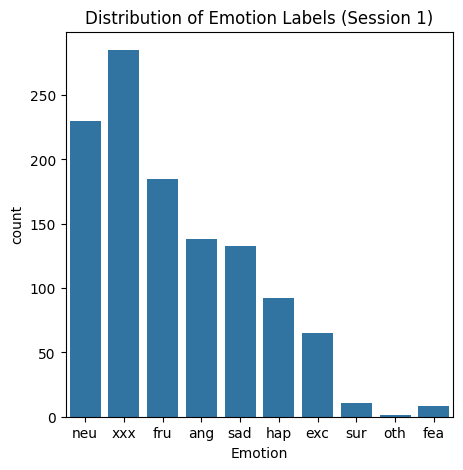

In [54]:
fig, ax =plt.subplots(figsize=(5,5))
sns.countplot(emotion_labels_subset, x="Emotion")
plt.title('Distribution of Emotion Labels (Session 1)')
fig.show()

# Prepare, Train, and Test Classification Model - Session 1-5 (Audio-Text ONLY)

## AUDIO-TEXT Session 1-5

In [ ]:
sessions_audiotext = ['Session1', 'Session2', 'Session4'] # Session 3 and Session 5 have different number of samples

# Read in complete audio/text data
audio_embedding_df_complete = pd.DataFrame()
text_embedding_df_complete = pd.DataFrame()
emotion_df_complete = pd.DataFrame()
for session in sessions_audiotext:
  curr_session_audio = pd.read_csv(f'./drive/MyDrive/coms6998_final_project/Embeddings/audio_embeddings_{session}.csv', header=None)
  audio_embedding_df_complete = pd.concat([audio_embedding_df_complete, curr_session_audio], ignore_index=True)

  curr_session_text = pd.read_csv(f'./drive/MyDrive/coms6998_final_project/Embeddings/text_embeddings_{session}.csv', header=None)
  text_embedding_df_complete = pd.concat([text_embedding_df_complete, curr_session_text], ignore_index=True)

  curr_emotions = pd.read_csv(f'./drive/MyDrive/coms6998_final_project/Embeddings/labels_{session}.csv', header=None, names=['Dialog_ID', 'Emotion'])
  emotion_df_complete = pd.concat([emotion_df_complete, curr_emotions], ignore_index=True)


# Read in emotion labels
emotion_labels = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/emotion_labels.csv', header=None, names=['Dialog_ID', 'Emotion'])
labels_subset = pd.read_csv('./drive/MyDrive/coms6998_final_project/Embeddings/Session 1/labels.csv', header=None, names=['Dialog_ID'])
emotion_labels_subset = emotion_labels.set_index('Dialog_ID').join(labels_subset.set_index('Dialog_ID'), on='Dialog_ID', how='right').reset_index()

# Add emotion label to single modality DFs to prepare for filtering
audio_embedding_df_complete['Emotion'] = emotion_labels_subset['Emotion']
text_embedding_df_complete['Emotion'] = emotion_labels_subset['Emotion']

# Filter single modality DFs to 4 emotions
y_labels = ['ang', 'hap', 'sad', 'neu']
audio_embedding_df_complete = audio_embedding_df_complete[audio_embedding_df_complete['Emotion'].isin(y_labels)]
text_embedding_df_complete = text_embedding_df_complete[text_embedding_df_complete['Emotion'].isin(y_labels)]

# Convert filtered single modality DFs into embeddings to combine
audio_embedding = torch.tensor(audio_embedding_df_complete.drop('Emotion', axis=1).values)
text_embedding = torch.tensor(text_embedding_df_complete.drop('Emotion', axis=1).values)

# Combine modalities
audio_text_embeddings = torch.softmax(audio_embedding @ text_embedding.T,
                                        dim=-1)
emotion_labels_subset = emotion_labels_subset[emotion_labels_subset['Emotion'].isin(y_labels)].reset_index()

# Add emotion labels to combined modality to prepare dataset for training
audio_text_data = pd.DataFrame(audio_text_embeddings)
audio_text_data['Emotion'] = emotion_labels_subset['Emotion']

####### Audio - Text Model

# Separate target variable
audio_text_x = audio_text_data.drop('Emotion', axis=1)
audio_text_y = audio_text_data['Emotion']

# Split data into dev and test datasets using 80:20 split
X_dev, X_test, y_dev, y_test = train_test_split(audio_text_x,
                                                audio_text_y,
                                                test_size=0.2,
                                                stratify=audio_text_y,
                                                random_state=1)

# Split dev data into train and validation datasets using 80:20 split
X_train, X_val, y_train, y_val = train_test_split(X_dev,
                                                  y_dev,
                                                  test_size=0.2,
                                                  stratify=y_dev,
                                                  random_state=1)

# Complete hyperparameter tuning to find optimal hyperparameters for NuSVC model
param_dist = {
    'nu': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
    'gamma': [0.001, 0.01, 0.1, 1.e+00, 10],
    'kernel': ['rbf', 'linear', 'poly'],
}

audio_text_model = NuSVC(random_state=42,
                           class_weight='balanced',
                           decision_function_shape='ovo')

random_search = RandomizedSearchCV(audio_text_model,
                                   param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42)

random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_scores_random = random_search.best_score_
print("Best set of hyperparameters: ", best_params_random)
print("Best score: ", best_scores_random)

Best set of hyperparameters:  {'nu': 0.4, 'kernel': 'rbf', 'gamma': 0.1}
Best score:  0.4168771929824562


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
93 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 250, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/li

In [6]:
## AUDIO TEXT SESSION 1-5 TEST

audio_text_model = NuSVC(nu=0.5,
                          gamma=0.1,
                          kernel='rbf',
                          class_weight='balanced',
                          random_state=42,
                          decision_function_shape='ovo')
audio_text_model.fit(X_train, y_train)
audio_text_pred = audio_text_model.predict(X_test)

# Calculate evaluation metrics
print(classification_report(y_test, audio_text_pred))

              precision    recall  f1-score   support

         ang       0.21      0.29      0.24        28
         hap       0.33      0.11      0.17        18
         neu       0.42      0.57      0.48        46
         sad       0.17      0.07      0.10        27

    accuracy                           0.32       119
   macro avg       0.28      0.26      0.25       119
weighted avg       0.30      0.32      0.29       119



## Class Distribution (Session 1-5)

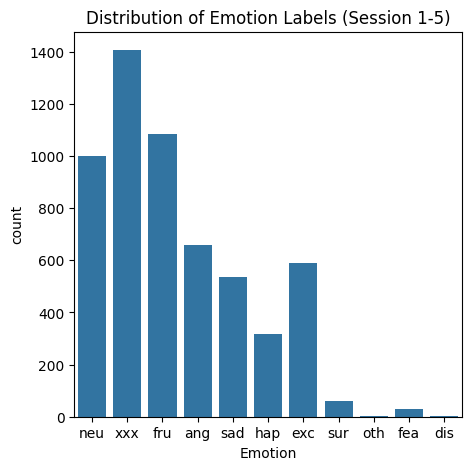

In [ ]:
fig, ax =plt.subplots(figsize=(5,5))
sns.countplot(emotion_df_complete, x="Emotion")
plt.title('Distribution of Emotion Labels (Session 1-5)')
fig.show()